## Team:

* **Chen Jingyu, A0236045L**
* **Shan Shenghao, A0116327L**
* **Yang Changyong, A0236000A**

## Data and Visualization

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random as rd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [114]:
df = pd.read_csv('bank-full.csv',delimiter=";")
#df.info()

In [115]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [116]:
jobs = df['job'].unique()
print(jobs)

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']


In [117]:
df['job'].value_counts()
# jobs = df.groupby('job')
# jobs = jobs.count()
# print(jobs.iloc[:,0])

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [118]:
sns.set(font_scale = 1)

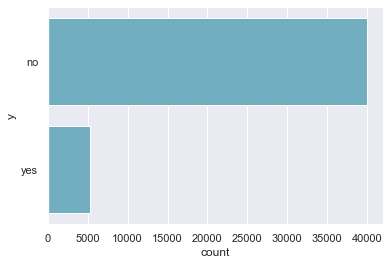

In [119]:
sns.countplot(y="y", data=df, color="c")

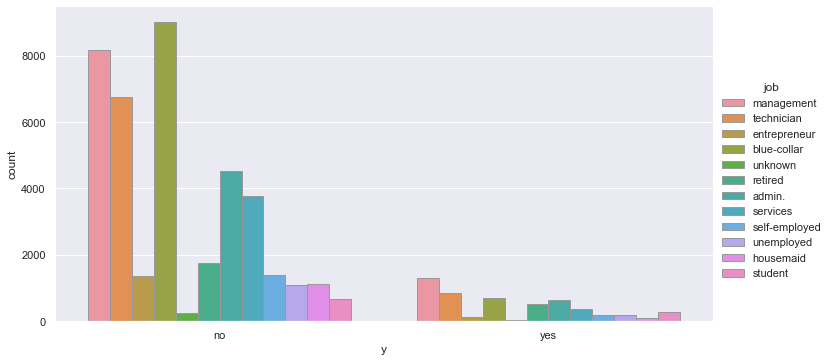

In [120]:
sns.catplot(x="y",kind="count", hue="job", data=df,edgecolor=".6",aspect=24/12)

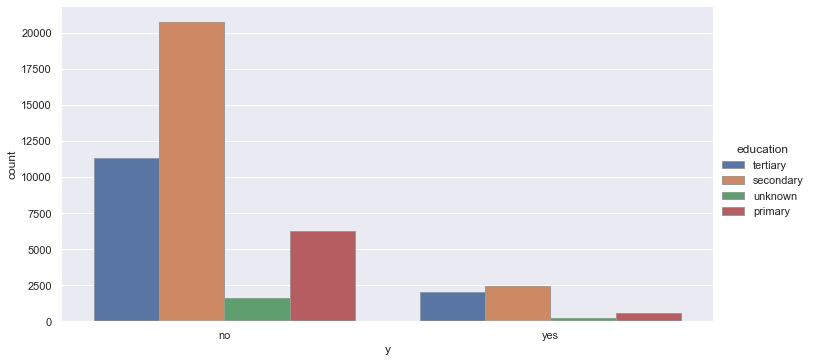

In [121]:
sns.catplot(x="y",kind="count", hue="education", data=df,edgecolor=".6",aspect=24/12)

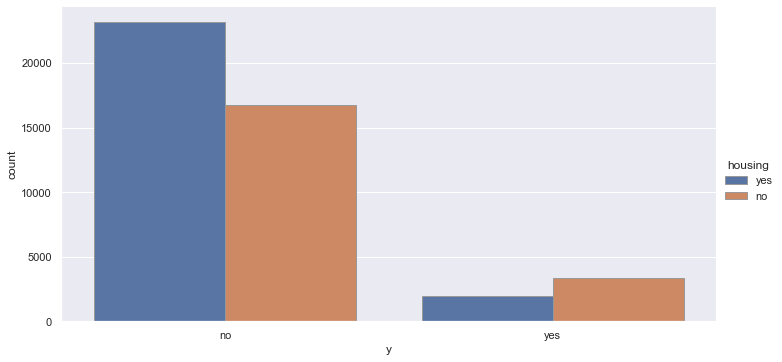

In [122]:
sns.catplot(x="y",kind="count", hue="housing", data=df,edgecolor=".6",aspect=24/12)

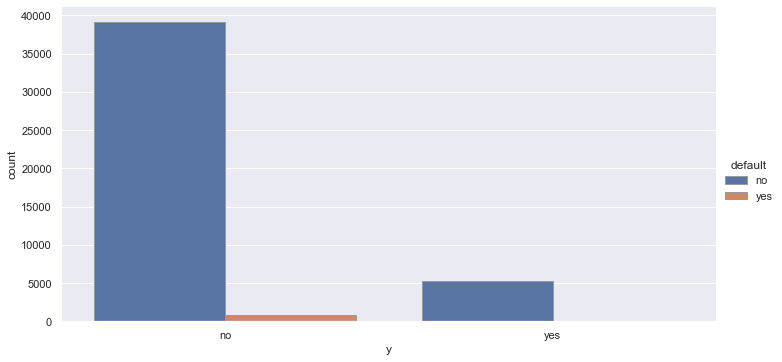

In [123]:
sns.catplot(x="y",kind="count", hue="default", data=df,edgecolor=".6",aspect=24/12)

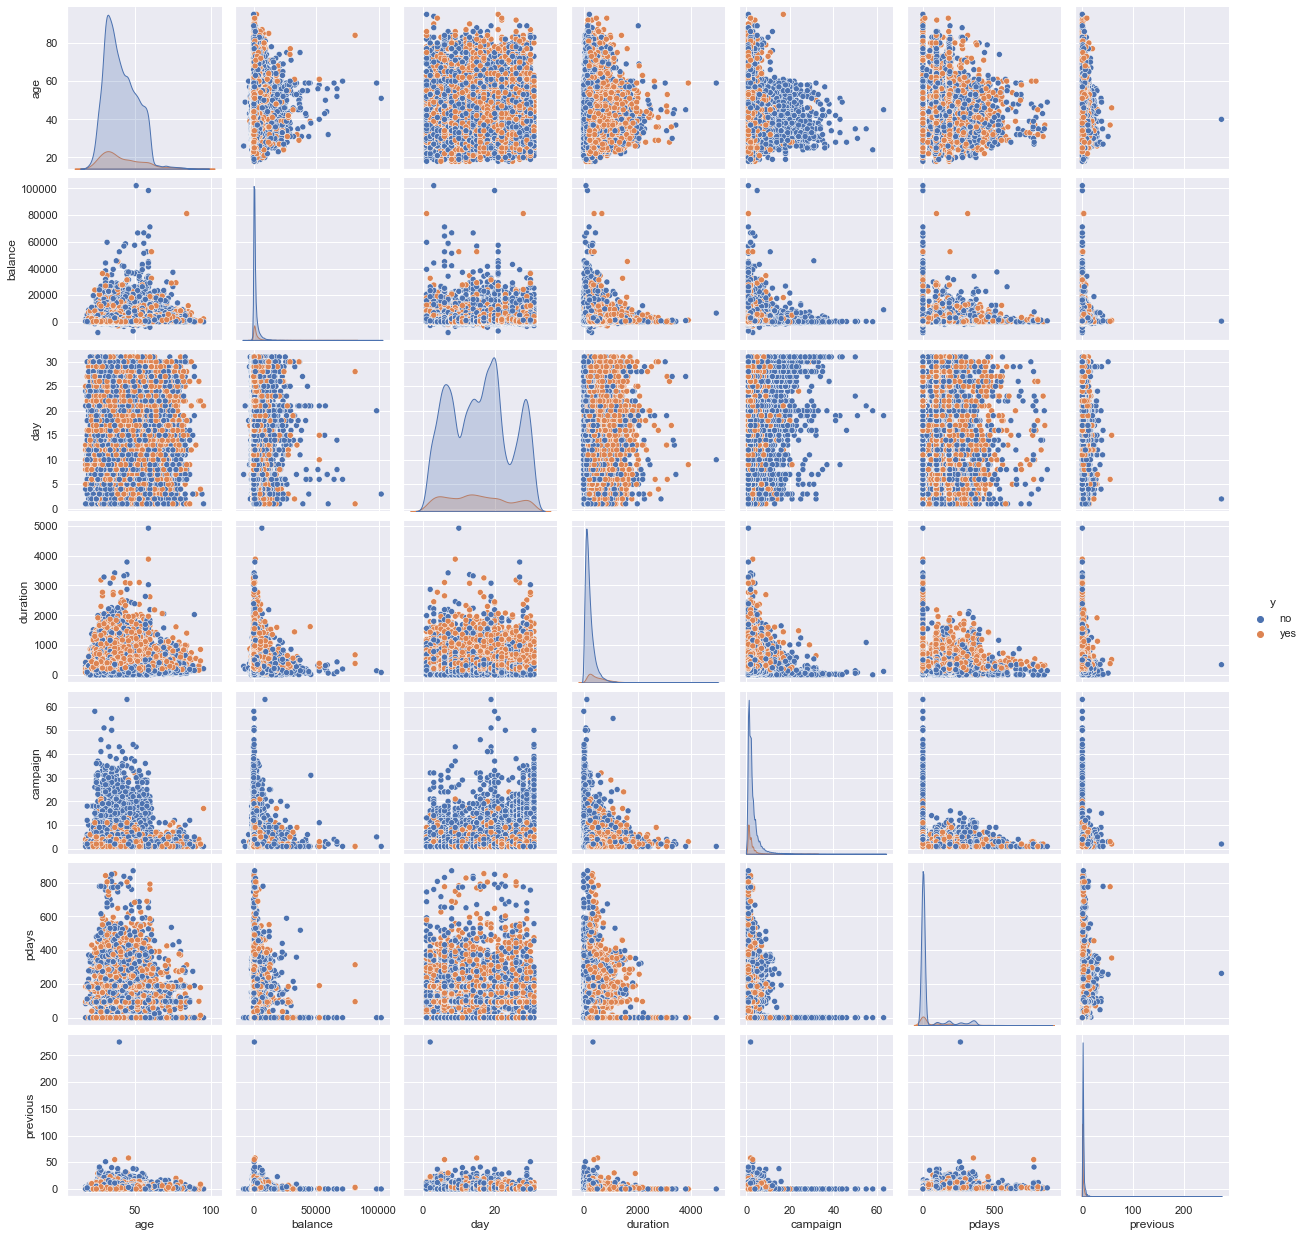

In [124]:
sns.pairplot(df, hue="y")

## Check for None values

In [125]:
df.isnull().values.any()

False

## Categorical values

In [126]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


In [127]:
object_cols = object_cols[:-1]

In [128]:
object_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

## Functions used for preprocessing

In [129]:
def FeatureTransform(df, transform_cols=None):

    feature_map={'poutcome':{'success':1,'unknown':0, 'failure':0, 'other':0},
                'month':{'jan':0,'feb':0.5,'mar':1,'apr':0.5,'may':0,'jun':1,'jul':0,'aug':0,'sep':1,'oct':1,'nov':0,'dec':1},
                'contact':{'cellular':1, 'telephone':1, 'unknown':0},
                'job':{'student':1, 'retired':1, \
                       'admin.':0.75, \
                       'management':0.5, 'technician':0.5, 'admin.':0.5, 'services':0.5, 'unemployed':0.5, \
                       'entrepreneur':0.25, 'blue-collar':0.25, 'unknown':0.25, 'self-employed':0.25, \
                       'housemaid':0},
                'education':{'primary':0, 'secondary':0.5, 'tertiary':1, 'unknown':0.5},
                'marital':{'single':1, 'divorced':0.5, 'married':0},
                'duration':lambda x: 0.75 if x>1800 else 1 if x>=900 else 0.5 if x>=600 else 0.25 if x>=300 else 0,
                'balance':lambda x: 1 if x>2000 else 0.75 if x>1000 else 0.5 if x>0 else 0.25 if x>-1000 else 0,
                'age':lambda x: 1 if x>60 or x<=25 else 0,
                'day':lambda x: 1 if x in [1,10] else 0,
                'campaign':lambda x: np.exp(-(x-1)/10.0),
                'pdays':lambda x: 1 if x>365 else 0 if x<0 else 0.5,
                'previous':lambda x: 1 if (x>0 and x<15) else 0,
                'default':{'yes':1,'no':0},
                'housing':{'yes':1,'no':0},
                'loan':{'yes':1,'no':0},
                }

    name_map={'poutcome':'poutcome_success',
             'month':'month_preferred',
             'contact':'contact_known',
             'job':'job_preferred',
             'education':'education_preferred',
             'marital':'marital_preferred',
             'default':'default_yes',
             'housing':'housing_yes',
             'loan':'loan_yes',
             'duration':'duration_transformed',
             'balance':'balance_high',
             'age': 'age_preferred',
             'day':'day_preferred',
             'campaign':'campaign_transformed',
             'pdays':'pdays_long',
             'previous':'previous_low'
            }
    
    if transform_cols is None:
        transform_cols = list(feature_map.keys())

    df_transformed = df.copy()
    for col in transform_cols:
        df_transformed[col] = df[col].map(feature_map[col])
    
    display(df_transformed.head())
    
    return df_transformed

def OneHotEncoding(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    object_cols.remove('y')

    df_onehot = df.copy()
    df_onehot = pd.get_dummies(df_onehot, columns=object_cols)
    lb_make = LabelEncoder()
    df_onehot['y'] = lb_make.fit_transform(df_onehot['y'])
    display(df_onehot.head())
    
    return df_onehot

def TrainTestSplit(df, test_size=0.10, random_state=1):
    df_features = df.drop('y', axis = 1)
    df_label = df['y']
    train_features, test_features, train_labels, test_labels = train_test_split(
        df_features, 
        df_label, 
        test_size = test_size, 
        stratify = df_label,
        random_state = random_state)
    count_train = np.unique(train_labels, return_counts=True)
    count_test = np.unique(test_labels, return_counts=True)
    
    print("train_features shape: ",train_features.shape)
    print("test_features shape: ", test_features.shape)
    
    return train_features, test_features, train_labels, test_labels

def FeatureScaling(train_features, test_features):

    s = (train_features.max()> 1) | (train_features.min() < 0)
    scale_cols = list(s[s].index)

    scaler = StandardScaler()
    train_features_scaled = train_features.copy()
    test_features_scaled = test_features.copy()

    train_features_scaled[scale_cols] = scaler.fit_transform(train_features[scale_cols])
    test_features_scaled[scale_cols] = scaler.transform(test_features[scale_cols])
    
    print('test_features_scaled describe:')
    display(test_features_scaled.describe())

    return train_features_scaled, test_features_scaled

def DataSampling(train_features, train_labels, sample_rate=0.2, random_state=1):
    rd.seed(random_state)
    sample_rows = rd.sample(list(train_features.index),int(sample_rate*len(list(train_features.index))))
    train_features_sample = train_features.loc[sample_rows]
    train_labels_sample = train_labels.loc[sample_rows]
    
    return train_features_sample, train_labels_sample
    

## OneHotEncoding + TrainTestSplit + FeatureScaling

In [130]:
df_onehot = OneHotEncoding(df)

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [131]:
train_features, test_features, train_labels, test_labels = TrainTestSplit(df_onehot)

train_features shape:  (40689, 51)
test_features shape:  (4522, 51)


In [132]:
train_features_scaled, test_features_scaled = FeatureScaling(train_features, test_features)

test_features_scaled describe:


,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
count,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,...,4522.000000,4522.000000,4522.000000,4522.000000,4522.00000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000
mean,-0.011606,-0.001474,0.025615,0.027048,-0.014618,0.016686,0.007642,0.106148,0.212295,0.031181,...,0.116762,0.011278,0.308713,0.093100,0.01747,0.013932,0.113003,0.041796,0.034719,0.810482
std,1.000419,0.956317,1.001936,1.016512,0.956676,1.021851,0.830283,0.308061,0.408978,0.173826,...,0.321173,0.105610,0.462013,0.290605,0.13103,0.117221,0.316632,0.200144,0.183088,0.391963
min,-2.161235,-1.139596,-1.776923,-1.001462,-0.568394,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.842750,-0.422100,-0.815456,-0.589158,-0.568394,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-0.183508,-0.301591,0.025827,-0.279930,-0.246975,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.664089,0.025517,0.746927,0.258789,0.074444,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.902074,26.110186,1.828578,13.720912,16.788221,8.027150,17.273642,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


## FeatureTransform + OneHotEncoding + TrainTestSplit + FeatureScaling

In [133]:
df_transformed = FeatureTransform(df, ['age','poutcome'])
df_transformed = OneHotEncoding(df_transformed)
train_features_transformed, test_features_transformed, train_labels_transformed, test_labels_transformed = TrainTestSplit(df_transformed)
train_features_transformed_scaled, test_features_transformed_scaled = FeatureScaling(train_features_transformed,test_features_transformed)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,0,no
1,0,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,0,no
2,0,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,0,no
3,0,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,0,no
4,0,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,0,no


,age,balance,day,duration,campaign,pdays,previous,poutcome,y,job_admin.,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0,2143,5,261,1,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,29,5,151,1,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,2,5,76,1,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1506,5,92,1,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,5,198,1,-1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


train_features shape:  (40689, 48)
test_features shape:  (4522, 48)
test_features_scaled describe:


,age,balance,day,duration,campaign,pdays,previous,poutcome,job_admin.,job_blue-collar,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
count,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,...,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.00000,4522.000000
mean,0.060593,-0.001474,0.025615,0.027048,-0.014618,0.016686,0.007642,0.034719,0.106148,0.212295,...,0.003981,0.054401,0.033171,0.151039,0.116762,0.011278,0.308713,0.093100,0.01747,0.013932
std,0.238608,0.956317,1.001936,1.016512,0.956676,1.021851,0.830283,0.183088,0.308061,0.408978,...,0.062973,0.226832,0.179103,0.358127,0.321173,0.105610,0.462013,0.290605,0.13103,0.117221
min,0.000000,-1.139596,-1.776923,-1.001462,-0.568394,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,-0.422100,-0.815456,-0.589158,-0.568394,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,-0.301591,0.025827,-0.279930,-0.246975,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.025517,0.746927,0.258789,0.074444,-0.410693,-0.247230,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
max,1.000000,26.110186,1.828578,13.720912,16.788221,8.027150,17.273642,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


## Functions used for performance evaluation

In [134]:
def PrintPerformance(algo, train_features, train_labels, test_features, test_labels):
    scorer = make_scorer(matthews_corrcoef)
    cv_score = cross_val_score(algo, train_features, train_labels, cv=5, scoring = scorer)
    print(cv_score)
    print ("Five-fold Cross Validation Score=", "%.4f" % np.mean(cv_score)) 

    #Predict the response for test dataset
    y_pred = algo.predict(test_features)
    print("Test MCC: ", matthews_corrcoef(test_labels, y_pred))
    # Compute accuracy
    #print(classification_report(test_labels, y_pred,target_names=['no', 'yes']))
    
    count_prediction = np.unique(y_pred, return_counts=True)
    print('Predicted Labels:', count_prediction[0], "=", count_prediction[1])
    
    ### Create confusion matrix
    conf_matrix = confusion_matrix (test_labels, y_pred)
    print (conf_matrix)

    ### Plot confusion matrix
    disp = plot_confusion_matrix(algo, test_features, test_labels, display_labels = ['no', 'yes'])

In [135]:
import warnings
warnings.filterwarnings("ignore")

## KNN

In [136]:
from sklearn.neighbors import KNeighborsClassifier

### Before scaling

[0.29215137 0.31162875 0.31446123 0.32438283 0.30171671]
Five-fold Cross Validation Score= 0.3089
Test MCC:  0.30075053217062747
Predicted Labels: [0 1] = [4211  311]
[[3829  164]
 [ 382  147]]


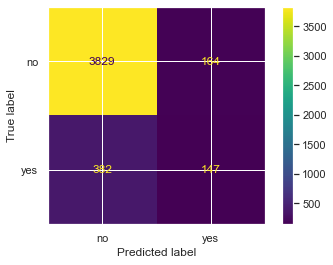

In [137]:
knn=KNeighborsClassifier()
knn.fit(train_features, train_labels)

PrintPerformance(knn, train_features, train_labels, test_features, test_labels)

### After scaling

[0.40001918 0.42333998 0.38590994 0.42288639 0.38683847]
Five-fold Cross Validation Score= 0.4038
Test MCC:  0.39234064871723395
Predicted Labels: [0 1] = [4204  318]
[[3858  135]
 [ 346  183]]


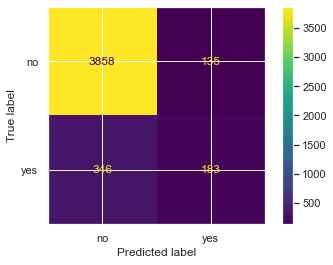

In [138]:
knn_scaled=KNeighborsClassifier()
knn_scaled.fit(train_features_scaled, train_labels)

PrintPerformance(knn_scaled, train_features_scaled, train_labels, test_features_scaled, test_labels)

### after encoding & scaling

In [139]:
df_transformed = FeatureTransform(df, ['age','poutcome','day','campaign', 'pdays','previous','default', 'housing','loan'])
##'poutcome','month','contact','job','education','marital','duration', 'balance','age'
##'day','campaign', 'pdays','previous','default', 'housing','loan'
df_transformed = OneHotEncoding(df_transformed)
train_features_transformed, test_features_transformed, train_labels_transformed, test_labels_transformed = TrainTestSplit(df_transformed)
train_features_transformed_scaled, test_features_transformed_scaled = FeatureScaling(train_features_transformed,test_features_transformed)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,management,married,tertiary,0,2143,1,0,unknown,0,may,261,1.0,0.0,0,0,no
1,0,technician,single,secondary,0,29,1,0,unknown,0,may,151,1.0,0.0,0,0,no
2,0,entrepreneur,married,secondary,0,2,1,1,unknown,0,may,76,1.0,0.0,0,0,no
3,0,blue-collar,married,unknown,0,1506,1,0,unknown,0,may,92,1.0,0.0,0,0,no
4,0,unknown,single,unknown,0,1,0,0,unknown,0,may,198,1.0,0.0,0,0,no


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0,0,2143,1,0,0,261,1.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,29,1,0,0,151,1.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,2,1,1,0,76,1.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1506,1,0,0,92,1.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,198,1.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


train_features shape:  (40689, 45)
test_features shape:  (4522, 45)
test_features_scaled describe:


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
count,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,...,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.000000,4522.00000,4522.000000
mean,0.060593,0.020345,-0.001474,0.561477,0.168288,0.021672,0.027048,0.868396,0.102167,0.187085,...,0.003981,0.054401,0.033171,0.151039,0.116762,0.011278,0.308713,0.093100,0.01747,0.013932
std,0.238608,0.141193,0.956317,0.496261,0.374164,0.145626,1.016512,0.168277,0.219236,0.390023,...,0.062973,0.226832,0.179103,0.358127,0.321173,0.105610,0.462013,0.290605,0.13103,0.117221
min,0.000000,0.000000,-1.139596,0.000000,0.000000,0.000000,-1.001462,0.004517,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,-0.422100,0.000000,0.000000,0.000000,-0.589158,0.818731,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,-0.301591,1.000000,0.000000,0.000000,-0.279930,0.904837,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,0.000000,0.025517,1.000000,0.000000,0.000000,0.258789,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,26.110186,1.000000,1.000000,1.000000,13.720912,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


[0.41724746 0.39357146 0.41768311 0.41327819 0.38787065]
Five-fold Cross Validation Score= 0.4059
Test MCC:  0.4047867356668442
Predicted Labels: [0 1] = [4160  362]
[[3833  160]
 [ 327  202]]


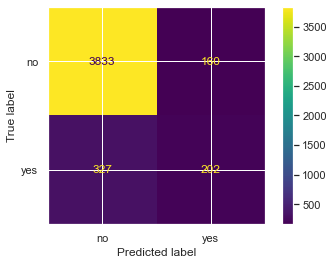

In [140]:
knn_eos=KNeighborsClassifier()
knn_eos.fit(train_features_transformed_scaled, train_labels)

PrintPerformance(knn_eos, train_features_transformed_scaled, train_labels, test_features_transformed_scaled, test_labels)

## SVM

In [141]:
from sklearn.svm import SVC

In [142]:
# Input a sample of training dataset into SVM to save runtime but accuracy might be impacted. 
train_features_sample, train_labels_sample = DataSampling(train_features, train_labels)

### Before scaling

[0.         0.02103327 0.0690264  0.04252199 0.        ]
Five-fold Cross Validation Score= 0.0265
Test MCC:  0.005634557423367178
Predicted Labels: [0 1] = [4516    6]
[[3988    5]
 [ 528    1]]


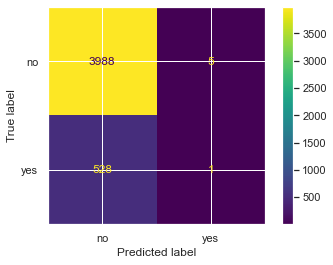

In [143]:
svm = SVC() # using default kernel 'rbf'
svm.fit(train_features_sample,train_labels_sample)

PrintPerformance(svm, train_features_sample, train_labels_sample, test_features, test_labels)

### After Scaling

In [144]:
train_features_scaled_sample, train_labels_sample = DataSampling(train_features_scaled, train_labels)

[0.40547912 0.33983204 0.39307917 0.47070032 0.40544863]
Five-fold Cross Validation Score= 0.4029
Test MCC:  0.3800558855019627
Predicted Labels: [0 1] = [4262  260]
[[3892  101]
 [ 370  159]]


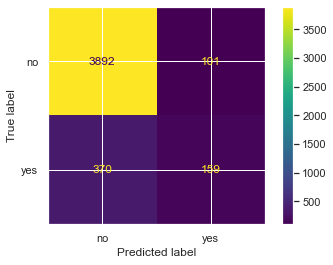

In [145]:
svm_scaled = SVC() # using default kernel 'rbf'
svm_scaled.fit(train_features_scaled_sample,train_labels_sample)

PrintPerformance(svm_scaled, train_features_scaled_sample, train_labels_sample, test_features_scaled, test_labels)

## Naive bayes

In [146]:
from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB

[0.38691406 0.37039791 0.39522772 0.38018006 0.40898341]
Five-fold Cross Validation Score= 0.3883
Test MCC:  0.35313355255679335
Predicted Labels: [0 1] = [3784  738]
[[3531  462]
 [ 253  276]]


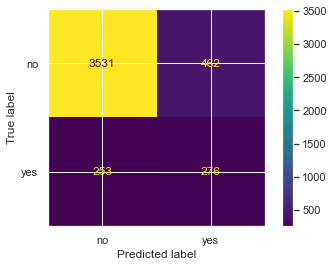

In [147]:
nb=GaussianNB()  
nb.fit(train_features, train_labels)

PrintPerformance(nb, train_features, train_labels, test_features, test_labels)

## Logistic Regression

In [148]:
from sklearn.linear_model import LogisticRegression

[0.33859534 0.33577921 0.29194359 0.31197856 0.31726064]
Five-fold Cross Validation Score= 0.3191
Test MCC:  0.30884757800471174
Predicted Labels: [0 1] = [4306  216]
[[3898   95]
 [ 408  121]]


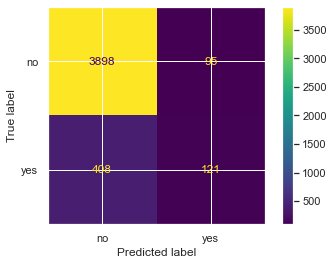

In [149]:
lr = LogisticRegression()
lr.fit(train_features,train_labels)

PrintPerformance(lr, train_features, train_labels, test_features, test_labels)

### Set class weight

[0.38334055 0.44239409 0.45977767 0.4639262  0.46697431]
Five-fold Cross Validation Score= 0.4433
Test MCC:  0.4636017022616097
Predicted Labels: [0 1] = [3881  641]
[[3662  331]
 [ 219  310]]


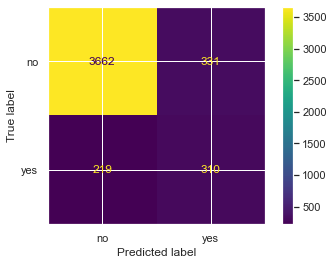

In [150]:
lr2 = LogisticRegression(class_weight={0:0.25, 1:0.75})
lr2.fit(train_features,train_labels)

PrintPerformance(lr2, train_features, train_labels, test_features, test_labels)

### How class weight affects sensitivity and specificity

In [151]:
import seaborn as sns

In [152]:
class_weights = []

for i in np.linspace(0.01,0.5,50, endpoint=True):

    lr_i = LogisticRegression(class_weight={0:i, 1:1-i})
    lr_i.fit(train_features,train_labels)

    y_pred = lr_i.predict(test_features)
    mcc = matthews_corrcoef(test_labels, y_pred)

    conf_matrix = confusion_matrix (test_labels, y_pred)
    sens = conf_matrix[1][1] /(conf_matrix[1][1] + conf_matrix[1][0])
    spec = conf_matrix[1][1] /(conf_matrix[1][1] + conf_matrix[0][1])

    class_weights.append((i,mcc,sens,spec))


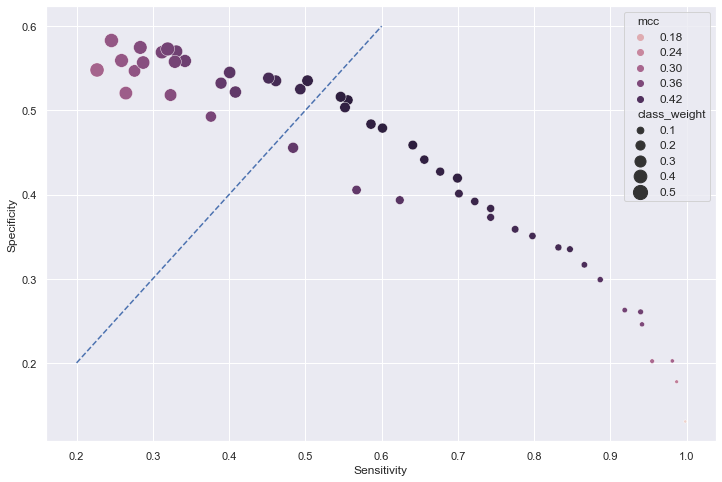

In [153]:
class_weights = pd.DataFrame(class_weights, columns=['class_weight','mcc','sensitivity','specificity'])

fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(x='sensitivity', y='specificity', data=class_weights, ax=ax, size='class_weight', hue='mcc', sizes=(10, 200))
ax.set_xlabel('Sensitivity', size=12)
ax.set_ylabel('Specificity', size=12)
ax.plot((0.2,0.6), (0.2,0.6), ls='--')

## Decision Tree

In [154]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

[0.44684021 0.39813134 0.41094578 0.40856593 0.39538382]
Five-fold Cross Validation Score= 0.4120
Test MCC:  0.39901376325166155
Predicted Labels: [0 1] = [3994  528]
[[3713  280]
 [ 281  248]]


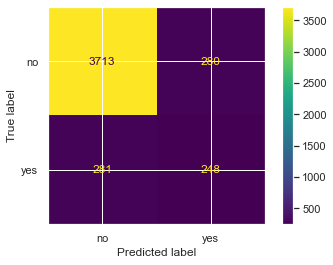

In [155]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier(random_state=1)  # We want to build a DT               
# Train Decision Tree Classifer
dt.fit(train_features,train_labels) # Fit the training data X and labels Y

PrintPerformance(dt, train_features, train_labels, test_features, test_labels)

## Random Forest

In [156]:
from sklearn.ensemble import RandomForestClassifier

[0.4699274  0.45834148 0.45916142 0.4806229  0.46005015]
Five-fold Cross Validation Score= 0.4656
Test MCC:  0.47885628917070727
Predicted Labels: [0 1] = [4169  353]
[[3868  125]
 [ 301  228]]


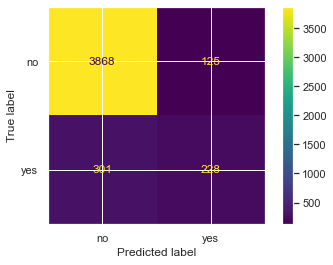

In [157]:
rf = RandomForestClassifier (random_state=1)
rf.fit(train_features, train_labels)

PrintPerformance(rf, train_features, train_labels, test_features, test_labels)

## Boosting

### AdaBoost

In [158]:
from sklearn.ensemble import AdaBoostClassifier

[0.43119654 0.4236648  0.42736229 0.4133405  0.44068121]
Five-fold Cross Validation Score= 0.4272
Test MCC:  0.4465637238342055
Predicted Labels: [0 1] = [4176  346]
[[3860  133]
 [ 316  213]]


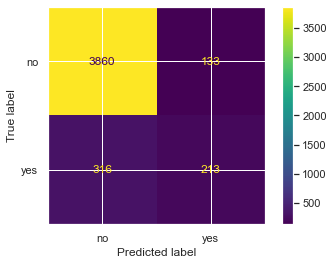

In [159]:
# Fit the model on training data
ada_clf = AdaBoostClassifier(random_state=1)
ada_clf.fit(train_features, train_labels)

PrintPerformance(ada_clf, train_features, train_labels, test_features, test_labels)

### GradientBoost

In [160]:
from sklearn.ensemble import GradientBoostingClassifier

[0.49392536 0.46802037 0.46741292 0.4881805  0.4716379 ]
Five-fold Cross Validation Score= 0.4778
Test MCC:  0.4675459017101695
Predicted Labels: [0 1] = [4165  357]
[[3861  132]
 [ 304  225]]


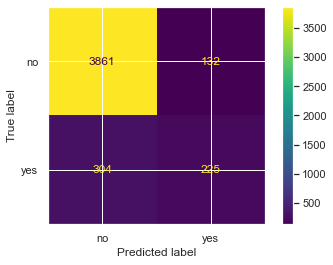

In [161]:
# Fit the model on training data
gb_clf = GradientBoostingClassifier( random_state=1)
gb_clf.fit(train_features, train_labels)

PrintPerformance(gb_clf, train_features, train_labels, test_features, test_labels)

## VotingClassifier

In [162]:
from sklearn.ensemble import VotingClassifier

[0.45676135 0.43467704 0.42337639 0.43305698 0.43266909]
Five-fold Cross Validation Score= 0.4361
Test MCC:  0.444814712022983
Predicted Labels: [0 1] = [4254  268]
[[3909   84]
 [ 345  184]]


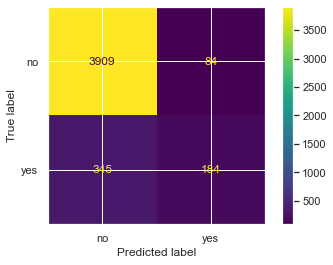

In [163]:
# Fit the model on training data
eclf1 = VotingClassifier(estimators=[('dt', dt), ('rf', rf), ('ada_clf', ada_clf), ('gb_clf', gb_clf)], voting='hard')
eclf1.fit(train_features, train_labels)

PrintPerformance(eclf1, train_features, train_labels, test_features, test_labels)

## Features Engineering

## Ordinal Features

In [67]:
def OrdinalFeatureEncoding(df):
    replace_map = {'education': {'secondary': 2, 'primary': 1, 'tertiary': 3, 'unknown': 2},
               'default':{'no':0, 'yes':1}, 
               'housing':{'no':0, 'yes':1},
               'loan': {'no':0, 'yes':1},
               'poutcome':{'success':1, 'failure':0, 'other':0.5, 'unknown':-1},
               'contact':{'cellular':1, 'telephone':0, 'unknown':0.5},
               #'marital':{'married':1, 'single':0, 'divorced':-1}
               #'month':{'jan':1,'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11,'dec':12 }
              }
    
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    object_cols.remove('y')

    for key in replace_map.keys():
        if key in object_cols:
            object_cols.remove(key)

    df_onehot = df.copy()
    df_onehot.replace(replace_map, inplace=True)
    df_onehot = pd.get_dummies(df_onehot, columns=object_cols)
    lb_make = LabelEncoder()
    df_onehot['y'] = lb_make.fit_transform(df_onehot['y'])
    display(df_onehot.head())
    
    return df_onehot

## OrdinalFeature Encoding + TrainTestSplit

In [68]:
df_ordinal = OrdinalFeatureEncoding(df)

,age,education,default,balance,housing,loan,contact,day,duration,campaign,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,58,3,0,2143,1,0,0.5,5,261,1,...,0,0,0,0,0,0,1,0,0,0
1,44,2,0,29,1,0,0.5,5,151,1,...,0,0,0,0,0,0,1,0,0,0
2,33,2,0,2,1,1,0.5,5,76,1,...,0,0,0,0,0,0,1,0,0,0
3,47,2,0,1506,1,0,0.5,5,92,1,...,0,0,0,0,0,0,1,0,0,0
4,33,2,0,1,0,0,0.5,5,198,1,...,0,0,0,0,0,0,1,0,0,0


In [69]:
train_features_ordinal, test_features_ordinal, train_labels_ordinal, test_labels_ordinal = TrainTestSplit(df_ordinal)

train_features shape:  (40689, 40)
test_features shape:  (4522, 40)


[0.48230581 0.4676547  0.46842194 0.47911996 0.47555321]
Five-fold Cross Validation Score= 0.4746
Test MCC:  0.4602708428515635
Predicted Labels: [0 1] = [4174  348]
[[3864  129]
 [ 310  219]]


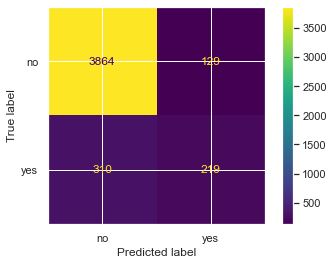

In [70]:
rf = RandomForestClassifier(random_state=1)
rf.fit(train_features_ordinal, train_labels_ordinal)

PrintPerformance(rf, train_features_ordinal, train_labels_ordinal, test_features_ordinal, test_labels_ordinal)

## Feature Selection

### references: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

## All features kept as one-hot features

In [71]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [78]:
def Iteratively_Select_Features_RF(train_features, train_labels, test_features, test_labels):
    # fit model on all training data
    features_filtered_list = []
    mccs_list = []
    model = RandomForestClassifier(random_state=1)
    model.fit(train_features, train_labels)
    # make predictions for test data and evaluate
    y_pred = model.predict(test_features)
    # Fit model using each importance as a threshold
    thresholds = sort(model.feature_importances_)
    
    i = 0
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(train_features)
        # train model
        selection_model = RandomForestClassifier(random_state=1)
        selection_model.fit(select_X_train,  train_labels)
        scorer = make_scorer(matthews_corrcoef)
        cv_score = cross_val_score(selection_model, select_X_train, train_labels, cv=5, scoring = scorer)
        
        # record CV mcc result
        mccs_list.append(np.mean(cv_score)*100.0)
        
        # record filtered feature
        feature_filtered = train_features.columns[np.where(model.feature_importances_>=thresh)[0]]
        features_filtered_list.append(feature_filtered)
        # eval model
        select_X_test = selection.transform(test_features)
        y_pred = selection_model.predict(select_X_test)
        mcc = matthews_corrcoef(test_labels, y_pred)
        print("%d: Thresh=%.3f, n=%d, CV=5 MCC: %.2f%%, Test MCC: %.2f%%, Features kept: %d" % (i,thresh, select_X_train.shape[1], np.mean(cv_score)*100.0, mcc*100, len(feature_filtered)))
        i+=1
    
    mccs_list = np.array(mccs_list, dtype="object").astype('float64')
    max_index = np.argmax(mccs_list)
    
    return max_index, features_filtered_list[max_index], mccs_list[max_index]

In [79]:
Iteratively_Select_Features_RF(train_features, train_labels, test_features, test_labels)

0: Thresh=0.001, n=51, CV=5 MCC: 46.56%, Test MCC: 47.89%, Features kept: 51
1: Thresh=0.001, n=50, CV=5 MCC: 46.37%, Test MCC: 46.53%, Features kept: 50
2: Thresh=0.001, n=49, CV=5 MCC: 45.56%, Test MCC: 46.16%, Features kept: 49
3: Thresh=0.003, n=48, CV=5 MCC: 45.77%, Test MCC: 43.82%, Features kept: 48
4: Thresh=0.004, n=47, CV=5 MCC: 46.46%, Test MCC: 45.77%, Features kept: 47
5: Thresh=0.004, n=46, CV=5 MCC: 45.57%, Test MCC: 45.49%, Features kept: 46
6: Thresh=0.004, n=45, CV=5 MCC: 46.78%, Test MCC: 45.60%, Features kept: 45
7: Thresh=0.004, n=44, CV=5 MCC: 46.48%, Test MCC: 45.17%, Features kept: 44
8: Thresh=0.005, n=43, CV=5 MCC: 46.61%, Test MCC: 46.18%, Features kept: 43
9: Thresh=0.005, n=42, CV=5 MCC: 46.33%, Test MCC: 45.08%, Features kept: 42
10: Thresh=0.005, n=41, CV=5 MCC: 46.78%, Test MCC: 47.96%, Features kept: 41
11: Thresh=0.005, n=40, CV=5 MCC: 46.30%, Test MCC: 45.51%, Features kept: 40
12: Thresh=0.005, n=39, CV=5 MCC: 46.70%, Test MCC: 45.58%, Features kept:

(15,
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
        'job_admin.', 'job_blue-collar', 'job_management', 'job_technician',
        'marital_divorced', 'marital_married', 'marital_single',
        'education_primary', 'education_secondary', 'education_tertiary',
        'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
        'contact_unknown', 'month_apr', 'month_aug', 'month_feb', 'month_jul',
        'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
        'month_sep', 'poutcome_failure', 'poutcome_success',
        'poutcome_unknown'],
       dtype='object'),
 47.69884930241097)

## Ordinal Features

In [80]:
Iteratively_Select_Features_RF(train_features_ordinal, train_labels_ordinal, test_features_ordinal, test_labels_ordinal)

0: Thresh=0.001, n=40, CV=5 MCC: 47.46%, Test MCC: 46.03%, Features kept: 40
1: Thresh=0.002, n=39, CV=5 MCC: 47.35%, Test MCC: 46.65%, Features kept: 39
2: Thresh=0.003, n=38, CV=5 MCC: 47.34%, Test MCC: 47.07%, Features kept: 38
3: Thresh=0.004, n=37, CV=5 MCC: 47.76%, Test MCC: 47.89%, Features kept: 37
4: Thresh=0.004, n=36, CV=5 MCC: 47.86%, Test MCC: 48.86%, Features kept: 36
5: Thresh=0.004, n=35, CV=5 MCC: 46.82%, Test MCC: 45.52%, Features kept: 35
6: Thresh=0.005, n=34, CV=5 MCC: 47.16%, Test MCC: 47.67%, Features kept: 34
7: Thresh=0.005, n=33, CV=5 MCC: 46.48%, Test MCC: 47.21%, Features kept: 33
8: Thresh=0.005, n=32, CV=5 MCC: 46.47%, Test MCC: 46.77%, Features kept: 32
9: Thresh=0.005, n=31, CV=5 MCC: 47.51%, Test MCC: 48.40%, Features kept: 31
10: Thresh=0.006, n=30, CV=5 MCC: 46.99%, Test MCC: 46.33%, Features kept: 30
11: Thresh=0.007, n=29, CV=5 MCC: 47.44%, Test MCC: 47.58%, Features kept: 29
12: Thresh=0.008, n=28, CV=5 MCC: 48.05%, Test MCC: 48.96%, Features kept:

(14,
 Index(['age', 'education', 'balance', 'housing', 'loan', 'contact', 'day',
        'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'job_admin.',
        'job_blue-collar', 'job_management', 'job_technician',
        'marital_married', 'marital_single', 'month_apr', 'month_aug',
        'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct',
        'month_sep'],
       dtype='object'),
 48.137335081401346)

In [82]:
## results from last step of iteratively filtering features
Features_kept = ['age', 'education', 'balance', 'housing', 'loan', 'contact', 'day',
        'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'job_admin.',
        'job_blue-collar', 'job_management', 'job_technician',
        'marital_married', 'marital_single', 'month_apr', 'month_aug',
        'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct',
        'month_sep']

## Random Forest GridSearchCV

In [83]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [84]:
df_features = df_ordinal.drop('y', axis = 1)
df_label = df_ordinal['y']

# use the best feature selection
df_features = df_features[Features_kept]

In [85]:
train_features, test_features, train_labels, test_labels = train_test_split(
        df_features, 
        df_label, 
        test_size = 0.10, 
        stratify = df_label, 
        random_state = 1)

In [86]:
# Initialize Parameters
n_estimators =  [int(x) for x in np.linspace(start = 100, stop = 2000, num = 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [i for i in range(2,11,1)]
min_samples_leaf = [i for i in range(1,11,1)]
min_weight_fraction_leaf = [i for i in np.arange(0.0,0.5,0.1)]
max_features = ['auto', 'sqrt', 'log2']
class_weight =  ['balanced', 'balanced_subsample']
bootstrap = [True, False]
max_samples = [i for i in np.arange(0.1, 0.5, 0.1)]
max_samples.append(None)

# Make Parameter Grid
parameters = {'n_estimators' : n_estimators,
            'criterion': criterion,
              'max_depth':max_depth,
              'min_samples_split' :min_samples_split,
              'min_samples_leaf':min_samples_leaf,
              'min_weight_fraction_leaf':min_weight_fraction_leaf,
              'max_features':max_features,
              'class_weight' : class_weight,
              'bootstrap' : bootstrap,
             'max_samples':max_samples}

In [87]:
## use MCC as the scorer
scorer = make_scorer(matthews_corrcoef)

rf = RandomForestClassifier(random_state=1)
gs_rf = RandomizedSearchCV(rf, parameters, scoring = scorer, cv =5, verbose= 1, n_iter=100, random_state = 1)
gs_rf.fit(train_features, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_samples': [0.1, 0.2,
                                                        0.30000000000000004,
                                                        0.4, N...
                                        

## Best Parameters Combination for RandomForest

In [88]:
gs_rf.best_params_

{'n_estimators': 1457,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_samples': 0.30000000000000004,
 'max_features': 'sqrt',
 'max_depth': 110,
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample',
 'bootstrap': False}

In [89]:
gs_rf.best_score_

0.575593868110102

In [90]:
#Predict the response for test dataset
y_pred = gs_rf.predict(test_features)
print("Test MCC: ",matthews_corrcoef(test_labels, y_pred))
#Compute accuracy
print(classification_report(test_labels, y_pred,target_names=['no', 'yes']))

Test MCC:  0.5332230222749209
              precision    recall  f1-score   support

          no       0.96      0.90      0.93      3993
         yes       0.49      0.73      0.59       529

    accuracy                           0.88      4522
   macro avg       0.73      0.82      0.76      4522
weighted avg       0.91      0.88      0.89      4522

